In [203]:
import pandas as pd
import numpy as np
import ast
from tqdm.autonotebook import tqdm
import shap
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from ModelProcessing.CategoricalEncoder import Encoder
from ModelProcessing.Filter_fights import Subset
from ModelProcessing.GetDifferenceBetweenFighterAttributes import GetTheDifferenceBetweenFighterAttributes
from PreProcessing.Imputer import Imputer
pd.set_option('display.max_columns', 200)

ufc = pd.read_csv('C:/Users/egnke/PythonCode/UFC/Cost-Sensitive-Modeling-UFC/data/engineered_features.csv')
print(ufc.shape)
ufc.tail()

(4310, 101)


,R_fighter,B_fighter,Average_Odds_f1,Average_Odds_f2,date,title_bout,win_by,weight_class,red_fighters_elo,blue_fighters_elo,red_Fighter_Odds,blue_Fighter_Odds,Winner,R_distance_beaten,R_distance_lost,R_Fight_Number,R_Stance,R_Height_cms,R_Reach_cms,R_age,R_WinLossRatio,R_Beaten_Names,R_Lost_to_names,R_RingRust,R_Winning_Streak,R_Losing_Streak,R_AVG_fight_time,R_total_title_bouts,R_Beaten_Similar,R_Takedown_Defense,R_Takedown Accuracy,R_Strikes_Per_Minute,R_Log_Striking_Ratio,R_Striking Accuracy,R_Strikes_Absorbed_per_Minute,R_Striking Defense,R_knockdows_per_minute,R_Submission Attempts,R_Average_Num_Takedowns,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Power_Rating,red_skill,wrestling_red_skill,striking_red_skill,g_and_p_red_skill,jiujitsu_red_skill,grappling_red_skill,R_Stats_of_Opponents_they_have_beaten,R_Stats_of_Opponents_they_have_lost_to,R_Log_Striking_Defense,R_Total_Takedown_Percentage,R_Log_total_takedown_percentage,B_Fight_Number,B_Stance,B_Height_cms,B_Reach_cms,B_age,B_WinLossRatio,B_RingRust,B_Winning_Streak,B_Beaten_Similar,B_Losing_Streak,B_AVG_fight_time,B_total_title_bouts,B_Takedown_Defense,B_Takedown Accuracy,B_distance_beaten,B_distance_lost,B_Strikes_Per_Minute,B_Striking Accuracy,B_Log_Striking_Ratio,B_Strikes_Absorbed_per_Minute,B_Striking Defense,B_knockdows_per_minute,B_Submission Attempts,B_Average_Num_Takedowns,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_Power_Rating,blue_skill,wrestling_blue_skill,striking_blue_skill,g_and_p_blue_skill,jiujitsu_blue_skill,grappling_blue_skill,B_Beaten_Names,B_Lost_to_names,B_Stats_of_Opponents_they_have_beaten,B_Stats_of_Opponents_they_have_lost_to,B_Log_Striking_Defense,B_Total_Takedown_Percentage,B_Log_total_takedown_percentage
4305,Dan Ige,Edson Barboza,127.0,-119.0,2020-05-16,False,Decision - Split,Featherweight,1321.715473,1336.420721,0.440529,0.543379,Red,4.686492,7.367932,7.0,Orthodox,170.18,180.34,28.0,0.833333,"['Mike Santiago', 'Jordan Griffin', 'Danny Hen...",['Julio Arce'],74.926631,5.0,0.0,10.278333,0.0,0,0.740000,0.542582,14.068946,0.321518,0.567316,2.547578,0.657726,0.153561,2.136752,8.136752,0.000000,0.142857,0.285714,0.142857,0.142857,0.0,0.044880,35.685169,31.394113,32.372439,33.848467,32.247186,30.728465,"[[-0.49137219619277717, 1.2701874044853967, -4...","[[-0.772345029971948, 1.2701874044853967, -4.6...",-0.466398,0.946429,-0.055060,23.0,Orthodox,180.34,190.50,34.0,0.636364,65.114311,0.0,0,2.0,11.050000,0.0,0.790726,0.363636,5.372853,4.590561,8.391682,0.455230,0.230896,4.415949,0.592981,0.068886,0.045455,0.495580,0.043478,0.043478,0.217391,0.304348,0.0,0.000000,0.143873,35.216548,31.393123,33.858937,18.077091,16.342737,29.776146,"['Mike Lullo', 'Anthony Njokuani', 'Ross Pears...","['Jamie Varner', 'Donald Cerrone', 'Michael Jo...","[[-2.116340114995228, 1.6758172400316624, 1.84...","[[1.4401028620182477, -0.40006205916005894, 0....",-0.528084,0.968668,-0.031833
4306,Claudia Gadelha,Angela Hill,-225.0,225.0,2020-05-16,False,Decision - Split,Women's Strawweight,1268.079474,1227.824266,0.692308,0.307692,Red,1.645990,3.138857,11.0,Orthodox,162.56,160.02,31.0,0.600000,"['Tina Lahdemaki', 'Jessica Aguilar', 'Cortney...","['Joanna Jedrzejczyk', 'Joanna Jedrzejczyk', '...",96.298589,1.0,0.0,14.803000,1.0,2,0.775510,0.507853,7.416092,0.039973,0.406996,4.094363,0.633298,0.004000,1.195050,3.535050,0.000000,0.090909,0.363636,0.000000,0.090909,0.0,0.001587,30.292615,32.055584,25.854353,26.560269,34.494477,33.249215,"[[1.5788591396064413, -1.7593690412095675, -0....","[[0.9570469142490475, -1.7593690412095675, -0....",-0.477799,0.945455,-0.056089,14.0,Orthodox,160.02,162.56,35.0,0.461538,119.932513,3.0,0,0.0,12.502308,0.0,0.541667,0.708333,3.785624,2.827027,6.916503,0.461628,0.081435,5.250654,0.631172,0.005128,0.153846,0.509221,0.000000,0.000000,0.357143,0.

In [144]:
def create_a_merge_column(df, fighter_one, fighter_two, date):
    
    df['merge'] = df[fighter_one] + df[fighter_two] 
    df['merge'] = df['merge'].apply(lambda x: x.replace(" ", "").replace(".",""))
    df['merge'] = df['merge'].apply(lambda x: ''.join(sorted(x)))
    df['merge'] = df['merge'] + df[date].astype(str)

    return(df)

data = pd.read_csv('C:/Users/egnke/PythonCode/UFC/Cost-Sensitive-Modeling-UFC/data/data.csv')

data = create_a_merge_column(data, 'R_fighter', 'B_fighter', 'date')
ufc = create_a_merge_column(ufc, 'R_fighter', 'B_fighter', 'date')
ufc = ufc.merge(data, on='merge',
                 how='left', suffixes=('', '_y'))
ufc.drop(ufc.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [145]:
# Subset Data
my_filter = Subset(ufc)
my_filter.subset_on_number_of_fights(number_of_fights=3)
my_filter.subset_on_draws
filtered_ufc = my_filter.df

# Encode Data
ufc_encoder = Encoder(filtered_ufc)
ufc_encoder.encode_weight_class
ufc_encoder.encode_title_bout
ufc_encoder.encode_winner
ufc_encoder.Difference_in_stances
encoded_ufc = ufc_encoder.df

# Impute missing values
imputer = Imputer(encoded_ufc)
cleaned_ufc = imputer.impute('bfill')
cleaned_ufc = imputer.impute_missing_values()

0%|          | 0/690 [00:00<?, ?it/s]Original Shape with all fights: (4310, 218)
New Shape with fighters over 3 fights (1607, 218)
Original Shape including Draws: (1607, 218)
New Shape with excluding draws(1579, 218)
100%|██████████| 690/690 [01:36<00:00,  7.18it/s]
These Columns have Missing Values['R_distance_beaten', 'B_Takedown_Defense', 'B_Takedown Accuracy', 'B_distance_beaten', 'Referee']
Finished Imputation


In [148]:
def drop_cols(df):
    df = df.copy()
    df.drop(['R_fighter', 'B_fighter', 'Average_Odds_f1', 'Average_Odds_f2',
                  'win_by','weight_class','Winner','B_Beaten_Names', 'B_Lost_to_names', 'R_Beaten_Names', 'R_Lost_to_names',
                  'B_Stats_of_Opponents_they_have_beaten',  'B_Stats_of_Opponents_they_have_lost_to',
                  'R_Stats_of_Opponents_they_have_beaten',  'R_Stats_of_Opponents_they_have_lost_to',],  axis=1, inplace=True)

    numeric_cols = df.select_dtypes([np.int, np.int64 , np.float, np.bool]).dtypes.index
    print('The following columns have been removed: '+ str(set(df.columns).symmetric_difference(numeric_cols)))
    
    new_df = df[numeric_cols]
    new_df['date'] = df['date']
    return new_df

ufc_cleaned = drop_cols(cleaned_ufc)

The following columns have been removed: {'merge', 'location', 'Referee', 'date'}


In [149]:
difference = GetTheDifferenceBetweenFighterAttributes(ufc_cleaned)
difference.get_difference_between_fighters_stats(cols_to_keep_whole=None)
ufc_cleaned = difference.get_data()

In [77]:
def check(clf, X, y):

    print(f'{classification_report(y, clf.predict(X))}')
    shap.initjs()
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    return shap.summary_plot(shap_values[1], X, plot_type='dot')


def cross_validate_catboost(X, y, **kwargs):
    import catboost, utils
    models = cross_validate(
             catboost.CatBoostClassifier(od_type='Iter',
                                         od_wait=10,
                                         eval_metric='AUC', 
                                         **kwargs
                                         ),
                             X, y,
                             fit=lambda m,Xt,yt,Xv,yv: m.fit(Xt, yt, eval_set=(Xv,yv),
                             cat_features=np.where(X.dtypes == 'category')[0],
                             verbose=0))
                             
    return pd.DataFrame(models)


def balancing_params(y):
    counts = y.value_counts()
    return { 'class_names': list(counts.index), 'class_weights': len(y) / counts.values }


X = ufc_cleaned.copy()
y = X.pop('Winner_encoded')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
model_forest = RandomForestClassifier(criterion='gini', max_depth=4, class_weight='balanced')
model_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

precision    recall  f1-score   support

           0       0.68      0.85      0.76       519
           1       0.88      0.72      0.79       744

    accuracy                           0.78      1263
   macro avg       0.78      0.79      0.77      1263
weighted avg       0.80      0.78      0.78      1263



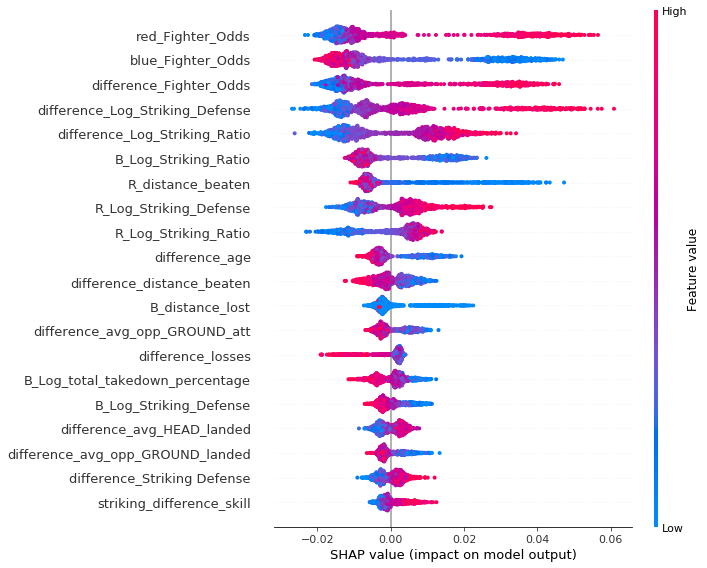

In [78]:
check(model_forest, X_train, y_train)

precision    recall  f1-score   support

           0       0.62      0.72      0.67       125
           1       0.80      0.71      0.75       191

    accuracy                           0.72       316
   macro avg       0.71      0.72      0.71       316
weighted avg       0.73      0.72      0.72       316



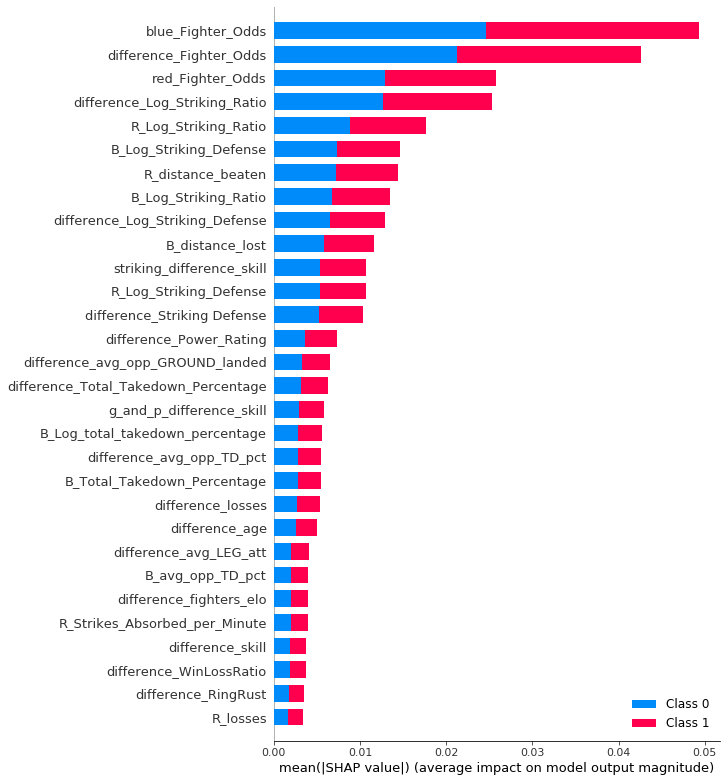

In [72]:
check(model_forest, X_test, y_test)

precision    recall  f1-score   support

           0       0.66      0.79      0.72       510
           1       0.84      0.72      0.78       753

    accuracy                           0.75      1263
   macro avg       0.75      0.76      0.75      1263
weighted avg       0.77      0.75      0.75      1263



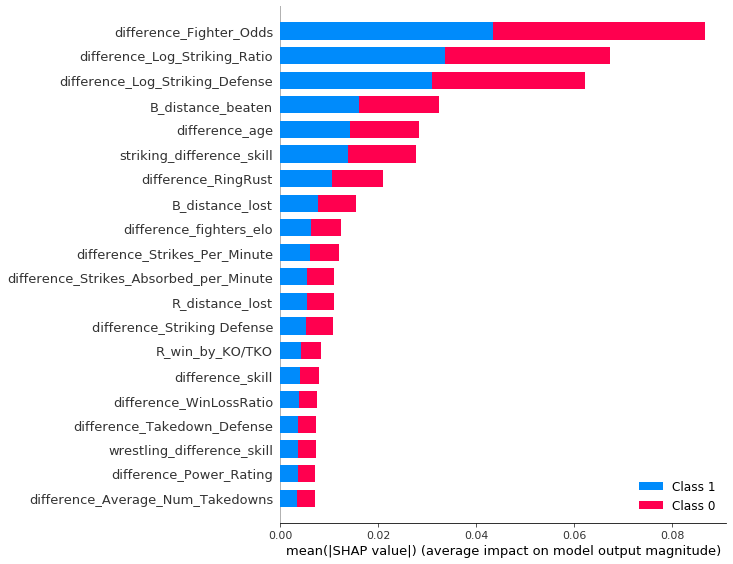

In [21]:
check(model_forest, X_train, y_train)

Training range: (2008-07-05 00:00:00, 2019-12-21 00:00:00)    Test range: 2020-01-18 00:00:00, 2020-01-18 00:00:00)
Training range: (2008-07-05 00:00:00, 2020-01-18 00:00:00)    Test range: 2020-01-25 00:00:00, 2020-01-25 00:00:00)
Training range: (2008-07-05 00:00:00, 2020-01-25 00:00:00)    Test range: 2020-02-08 00:00:00, 2020-02-08 00:00:00)
Training range: (2008-07-05 00:00:00, 2020-02-08 00:00:00)    Test range: 2020-02-15 00:00:00, 2020-02-15 00:00:00)
Training range: (2008-07-05 00:00:00, 2020-02-15 00:00:00)    Test range: 2020-02-22 00:00:00, 2020-02-22 00:00:00)
Training range: (2008-07-05 00:00:00, 2020-02-22 00:00:00)    Test range: 2020-02-29 00:00:00, 2020-02-29 00:00:00)
Training range: (2008-07-05 00:00:00, 2020-02-29 00:00:00)    Test range: 2020-03-07 00:00:00, 2020-03-07 00:00:00)
Training range: (2008-07-05 00:00:00, 2020-03-07 00:00:00)    Test range: 2020-03-14 00:00:00, 2020-03-14 00:00:00)
Training range: (2008-07-05 00:00:00, 2020-03-14 00:00:00)    Test range

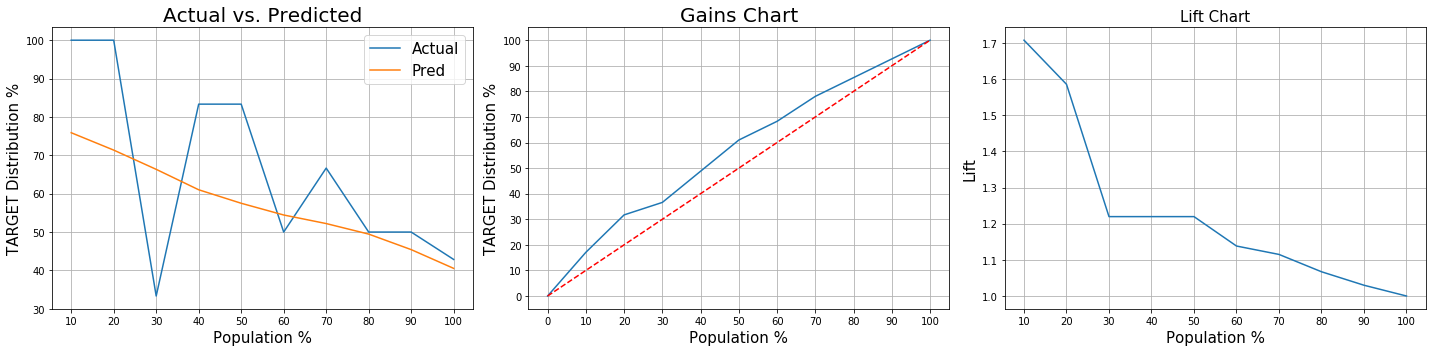

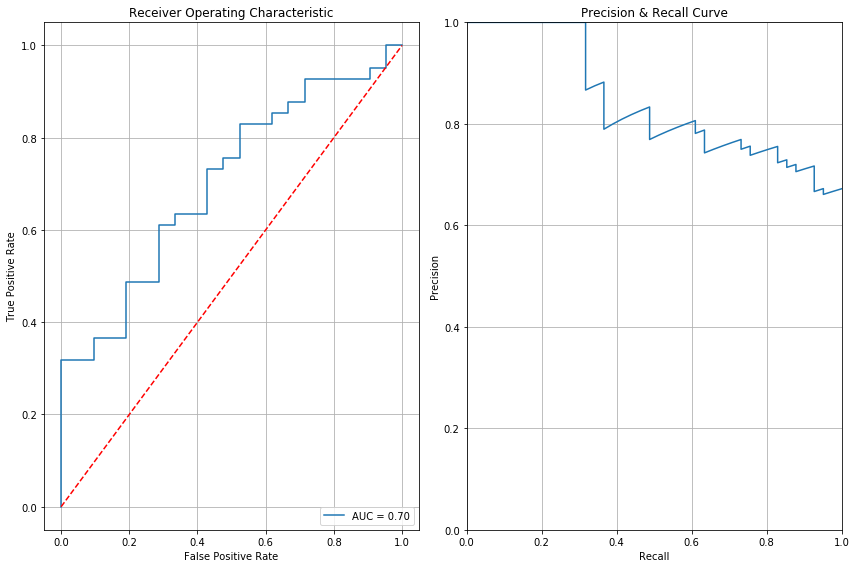

In [216]:
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.metrics import roc_curve, auc, precision_recall_curve

class BackTest:
    

    def __init__(self, df, model, date_range, y):

        self.model = model
        self.date_range = date_range
        self.df = df.copy()
        self.df = create_datetime_index(self.df, 'date')
        self.most_recent_date = self.df.index.max()
        self.dates = self.df.index.unique().to_list()
        self.y = y


    @staticmethod
    def create_datetime_index(df, date_col):

        if not date_col in df.columns:
            raise AttributeError('The column ' + str(date_col) + ' does not exist!')

        datetime_series = pd.to_datetime(df[date_col])
        datetime_index = pd.DatetimeIndex(datetime_series.values)
        df.set_index(datetime_index, inplace=True)
        df.drop(date_col, axis=1, inplace=True)
        return df


    @staticmethod
    def add_months(date_str, months):

        date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
        month = date.month - 1 + months
        year = date.year + month // 12
        month = month % 12 + 1
        day = min(date.day, calendar.monthrange(year,month)[1])
        
        return datetime.date(year, month, day).strftime("%Y-%m-%d")


    @staticmethod
    def check_if_tuple(obj):

        if isinstance(obj, tuple):
            return True
        else:
            return False

    
    def initlize_index(self):

        df = self.df.copy()
        if self.check_if_tuple(self.date_range):

            filtered_df = df[self.date_range[0]:self.date_range[1]]
            index = self.dates.index(max(filtered_df.index))

            return index

        else:

            filtered_df = df[:self.date_range]
            index = self.dates.index(max(filtered_df.index))

            return index


    def filter_data_by_index(self, df, date_range):

        df = df.copy()
        if self.check_if_tuple(date_range):

            X_train = df[date_range[0]:date_range[1]]
            y_train = X_train.pop(self.y)

            index = self.dates.index(max(X_train.index))
            X_test = df[self.dates[index+1]:self.dates[index+1]]
            y_test = X_test.pop(self.y)

            return X_train, X_test, y_train, y_test, index

        else:

            X_train = df[:date_range]
            y_train = X_train.pop(self.y)

            index = self.dates.index(max(X_train.index))
            X_test = df[self.dates[index+1]:self.dates[index+1]]
            y_test = X_test.pop(self.y)

            return X_train, X_test, y_train, y_test, index


    def update_date_range(self, date_range, index):

        if self.check_if_tuple(date_range):
            new_date   = self.dates[index+1]
            new_date_range = (date_range[0], new_date)
            return new_date_range

        else:
            new_date   = self.dates[index+1]
            new_date_range = new_date
            return new_date_range


    def fit(self):

        index = self.initlize_index()
        probas = []
        y_true = []
        while self.dates[index+1] != self.most_recent_date:
            
            X_train, X_test, y_train, y_test, index = self.filter_data_by_index(self.df, self.date_range)

            #preds.append(self.model.fit(X_train, y_train).predict_proba(X_test)[:,1])
            probas.append(self.model.fit(X_train, y_train).predict_proba(X_test)[:,1])
            y_true.append(y_test.values)
            self.date_range = self.update_date_range(self.date_range, index)
            
            print('Training range: (' + str(X_train.index.min()) +  ', ' + str(X_train.index.max()) +')' + '    Test range: ' \
                   + str(X_test.index.min()) + ', ' + str(X_test.index.max()) +')' )

        y_true = np.concatenate(y_true).ravel()
        probas = np.concatenate(probas).ravel()

        preds = np.where(probas > 0.5, 1, 0)
        print(f'{classification_report(y_true, preds)}')
        LiftGainChart(y_true=y_true, probas=probas)
        BuildROCandPrecisionRecall(y_true=y_true, probas=probas)


six_months_ago = date.today() + relativedelta(months=-6)
model = RandomForestClassifier(criterion='gini', max_depth=4, random_state=40)
backtest = BackTest(ufc_cleaned, model, date_range=six_months_ago, y='Winner_encoded')
backtest.fit()

In [213]:
class LiftGainChart:

    def __init__(self, y_true, probas):

        self.y_true = y_true
        self.probas = probas
        self.Charts()

    
    def CreateDeciles(self):

        decile = pd.DataFrame(self.probas, columns=['SCORE'])
        decile['DECILE'] = pd.qcut(decile['SCORE'].rank(method='first'), 10, labels=[10,9,8,7,6,5,4,3,2,1])
        decile['DECILE'] = decile['DECILE'].astype(float)
        decile['TARGET'] = self.y_true
        decile['NONTARGET'] = 1 - self.y_true
        return decile

    @staticmethod    
    def plots(agg1, target, type):

        plt.figure(1, figsize=(20, 5))
        plt.subplot(131)
        plt.plot(agg1['DECILE'], agg1['ACTUAL'], label='Actual')
        plt.plot(agg1['DECILE'], agg1['PRED'], label='Pred')
        plt.xticks(range(10, 110, 10))
        plt.legend(fontsize=15)
        plt.grid(True)
        plt.title('Actual vs. Predicted', fontsize=20)
        plt.xlabel('Population %', fontsize=15)
        plt.ylabel(str(target) + ' ' + str(type) + ' %', fontsize=15)

        plt.subplot(132)
        X = agg1['DECILE'].to_list()
        X.append(0)
        Y = agg1['DIST_TAR'].to_list()
        Y.append(0)
        plt.plot(sorted(X), sorted(Y))
        plt.plot([0, 100], [0, 100], 'r--')
        plt.xticks(range(0, 110, 10))
        plt.yticks(range(0, 110, 10))
        plt.grid(True)
        plt.title('Gains Chart', fontsize=20)
        plt.xlabel('Population %', fontsize=15)
        plt.ylabel(str(target) + ' Distribution %', fontsize=15)

        plt.subplot(133)
        plt.plot(agg1['DECILE'], agg1['LIFT'])
        plt.xticks(range(10, 110, 10))
        plt.grid(True)
        plt.title('Lift Chart', fontsize=15)
        plt.xlabel('Population %', fontsize=15)
        plt.ylabel('Lift', fontsize=15)
        plt.tight_layout()


    def Charts(self):

        data = self.CreateDeciles()
        inputs = list(['DECILE'])
        inputs.extend(('TARGET','SCORE'))

        decile = data[inputs]
        grouped = decile.groupby(['DECILE'])
        agg1 = pd.DataFrame({}, index=[])
        agg1['ACTUAL'] = grouped.mean()['TARGET']*100
        agg1['PRED']   = grouped.mean()['SCORE']*100
        agg1['DIST_TAR'] = grouped.sum()['TARGET'].cumsum()/grouped.sum()['TARGET'].sum()*100
        agg1.index.name = 'DECILE'
        agg1.reset_index(inplace=True)
        agg1['DECILE'] = agg1['DECILE']*10
        agg1['LIFT'] = agg1['DIST_TAR']/agg1['DECILE']

        self.plots(agg1, 'TARGET', 'Distribution')


class BuildROCandPrecisionRecall:

    def __init__(self, y_true, probas):

        self.y_true = y_true
        self.probas = probas
        self.Plot()

    
    def Build_ROC(self):

        fpr, tpr, threshold = roc_curve(self.y_true, self.probas)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        agg1 = pd.DataFrame({}, index=[])
        agg1['FPR'] = fpr
        agg1['TPR'] = tpr

        plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.grid(True)


    def Build_Precision_Recall(self):

        precision, recall, threshold = precision_recall_curve(self.y_true, self.probas)
        F1 = 2*(precision*recall)/((precision + recall))
        plt.title('Precision & Recall Curve')
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim((0, 1))
        plt.xlim((0, 1))
        plt.grid(True)


    def Plot(self):
        plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        self.Build_ROC()
        plt.subplot(1, 2, 2)
        self.Build_Precision_Recall()
        plt.tight_layout()




precision    recall  f1-score   support

           0       0.63      0.76      0.69       125
           1       0.82      0.71      0.76       191

    accuracy                           0.73       316
   macro avg       0.72      0.73      0.72       316
weighted avg       0.74      0.73      0.73       316



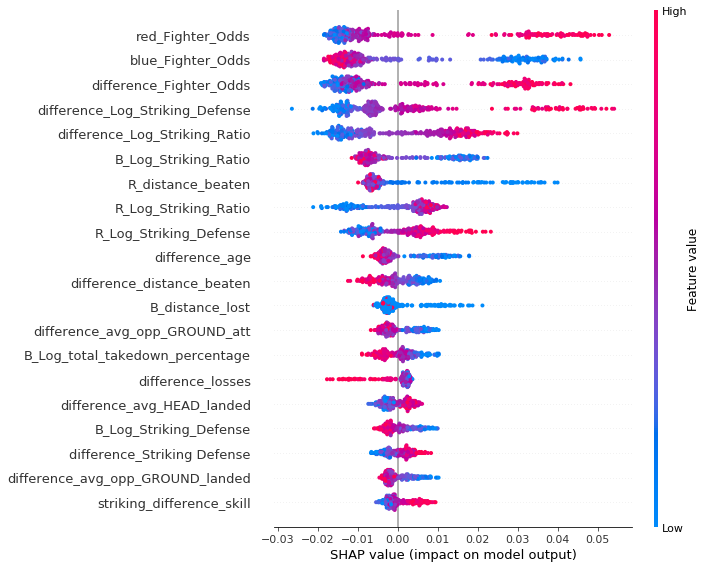

In [182]:
check(model_forest, X_test, y_test)

In [24]:
X[['difference_Fighter_Odds','difference_Log_Striking_Ratio','difference_Log_Striking_Defense',
                    'difference_age', 'difference_RingRust','striking_difference_skill','difference_fighters_elo','difference_Takedown_Defense',
                    'wrestling_difference_skill','difference_Power_Rating','g_and_p_difference_skill','jiujitsu_difference_skill','R_win_by_KO/TKO']]

,difference_Fighter_Odds,difference_Log_Striking_Ratio,difference_Log_Striking_Defense,difference_age,difference_RingRust,striking_difference_skill,difference_fighters_elo,difference_Takedown_Defense,wrestling_difference_skill,difference_Power_Rating,g_and_p_difference_skill,jiujitsu_difference_skill,R_win_by_KO/TKO
169,0.472990,1.102452,-0.039221,-10.0,10.883437,9.588448,24.195311,-0.493386,1.979016,-0.111111,3.408491,-15.063475,0.000000
171,0.136033,0.197858,-0.115100,-7.0,8.403500,1.864602,2.521583,-0.083333,0.980880,0.110317,1.864602,5.128210,0.250000
189,0.178641,0.786744,0.361191,7.0,-20.753831,6.780566,7.033930,-0.107071,6.786315,-0.045834,6.148363,6.332113,0.500000
198,-0.412069,1.491458,0.287114,6.0,13.129770,4.981481,-3.852588,-0.055556,-1.961440,0.016667,8.021881,-1.104099,0.250000
219,0.506691,0.026617,0.232953,6.0,-7.816285,2.112408,66.823918,0.498932,9.787561,-0.027775,-3.338966,5.317693,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305,-0.102850,0.090622,0.061686,-6.0,9.812320,-1.486498,-14.705249,-0.050726,0.000990,-0.098993,15.771376,15.904449,0.142857
4307,0.246680,0.823087,-0.377351,0.0,-6.556693,3.541576,23.094774,-0.475000,-9.751309,0.018251,-4.034090,4.325353,0.100000
4303,0.296228,1.003269,0.194499,-5.0,1.080584,0.240543,-77.534748,0.089021,0.530992,-0.003991,7.918364,-3.150489,0.400000
4304,-0.026066,-0.619278,-0.208212,3.0,-31.262787,-0.160089,11.790678,-0.078720,0.878551,0.032938,-8.017109,4.354178,0.333333


In [164]:
x = [1,2,3,4,5,6]

x[:2]

x[2:3]

[3]

In [121]:
def create_datetime_index(df, date_col):

    df = df.copy()
    if not date_col in df.columns:
        raise AttributeError('The column ' + str(date_col) + ' does not exist!')

    datetime_series = pd.to_datetime(df[date_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df.set_index(datetime_index, inplace=True)
    df.drop(date_col, axis=1, inplace=True)
    return df

chess = create_datetime_index(ufc, 'date')
chess['2005-05-01':'2013-08-31']
y = chess.index.unique().to_list()
#chess[y[0]:y[10]]
max(chess.index)

Timestamp('2020-05-16 00:00:00')

In [104]:
import calendar
import datetime

def add_months(date_str, months):

    date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
    month = date.month - 1 + months
    year = date.year + month // 12
    month = month % 12 + 1
    day = min(date.day, calendar.monthrange(year,month)[1])
    
    return datetime.date(year, month, day).strftime("%Y-%m-%d")

date_time_str = '2007-09-19'

add_months(date_time_str, 4)

'2008-01-19'

In [94]:
date_time_obj.strftime("%Y-%m-%d")

'2007-09-19'

In [168]:
chess['2007-06-23':'2007-06-23']

,R_fighter,B_fighter,Average_Odds_f1,Average_Odds_f2,title_bout,win_by,weight_class,red_fighters_elo,blue_fighters_elo,red_Fighter_Odds,blue_Fighter_Odds,Winner,R_distance_beaten,R_distance_lost,R_Fight_Number,R_Stance,R_Height_cms,R_Reach_cms,R_age,R_WinLossRatio,R_Beaten_Names,R_Lost_to_names,R_RingRust,R_Winning_Streak,R_Losing_Streak,R_AVG_fight_time,R_total_title_bouts,R_Beaten_Similar,R_Takedown_Defense,R_Takedown Accuracy,R_Strikes_Per_Minute,R_Log_Striking_Ratio,R_Striking Accuracy,R_Strikes_Absorbed_per_Minute,R_Striking Defense,R_knockdows_per_minute,R_Submission Attempts,R_Average_Num_Takedowns,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Power_Rating,red_skill,wrestling_red_skill,striking_red_skill,g_and_p_red_skill,jiujitsu_red_skill,grappling_red_skill,R_Stats_of_Opponents_they_have_beaten,R_Stats_of_Opponents_they_have_lost_to,R_Log_Striking_Defense,R_Total_Takedown_Percentage,R_Log_total_takedown_percentage,B_Fight_Number,B_Stance,B_Height_cms,B_Reach_cms,B_age,B_WinLossRatio,B_RingRust,B_Winning_Streak,B_Beaten_Similar,B_Losing_Streak,B_AVG_fight_time,B_total_title_bouts,B_Takedown_Defense,B_Takedown Accuracy,B_distance_beaten,B_distance_lost,B_Strikes_Per_Minute,B_Striking Accuracy,B_Log_Striking_Ratio,B_Strikes_Absorbed_per_Minute,B_Striking Defense,B_knockdows_per_minute,B_Submission Attempts,B_Average_Num_Takedowns,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_Power_Rating,blue_skill,wrestling_blue_skill,striking_blue_skill,g_and_p_blue_skill,jiujitsu_blue_skill,grappling_blue_skill,B_Beaten_Names,B_Lost_to_names,B_Stats_of_Opponents_they_have_beaten,B_Stats_of_Opponents_they_have_lost_to,B_Log_Striking_Defense,B_Total_Takedown_Percentage,B_Log_total_takedown_percentage
2007-06-23,Thales Leites,Floyd Sword,-450.0,400.0,False,Submission,Middleweight,NaN,NaN,0.818182,0.200000,Red,9999.0,9999.0,1.0,Orthodox,185.42,198.12,25.0,NaN,[],[],NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],NaN,NaN,0.0,1.0,Orthodox,182.88,NaN,30.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,9999.0,9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],[],NaN,NaN,0.0
2007-06-23,Roger Huerta,Doug Evans,-750.0,550.0,False,KO/TKO,Lightweight,NaN,NaN,0.882353,0.153846,Red,9999.0,9999.0,1.0,Orthodox,175.26,177.80,24.0,NaN,[],[],NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],NaN,NaN,0.0,1.0,Orthodox,175.26,NaN,26.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,9999.0,9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],[],NaN,NaN,0.0
2007-06-23,Joe Lauzon,Brandon Melendez,-475.0,425.0,False,Submission,Lightweight,NaN,NaN,0.826087,0.190476,Red,9999.0,9999.0,1.0,Orthodox,177.80,180.34,23.0,NaN,[],[],NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],NaN,NaN,0.0,1.0,Southpaw,180.34,NaN,24.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,9999.0,9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],[],NaN,NaN,0.0
2007-06-23,BJ Penn,Jens Pulver,280.0,-330.0,False,Submission,Lightweight,NaN,NaN,0.263158,0.767442,Red,9999.0,9999.0,1.0,Orthodox,175.26,177.80,28.0,NaN,[],[],NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,4.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],NaN,NaN,0.0,1.0,Southpaw,170.18,177.8,32.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,9999.0,9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,3.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],[],NaN,NaN,0.0
2007-06-23,Cole Miller,Andy Wang,-450.0,475.0,False,KO/TKO,Lightweight,NaN,NaN,0.818182,0.173913,Red,9999.0,9999.0,1.0,Orthodox,185.42,187.96,23.0,NaN,[],[],N